# Visualization of Generated Exponential Random Graph

The purpose of this notebook is to visualize generated graphs from the implementation of Metropolis-Hastings algorithm in the `ergm` package. Since it is deeply random, testing this function could be hard. We hope by visualizing generated graphs for different inputs pinpoint possible errors in the code.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import random; random.seed(1000)
import sys; sys.path.append('..')  # To access our package
from ergm.model import Model, sufficient
from ergm import sampling, dataset

We intend to use a common graph and a graph comming from real-world data, which are the graph from the karate club data set. Recall that the karate club data set is composed by only one graph.

In [2]:
# Load the karate graph
karate_dir = os.path.join('..', 'data', 'karate')
karate_filename = 'out.ucidata-zachary'
karate_graph = dataset.get_karate_graph(karate_dir, karate_filename)

# Create a complete graph with 5 vertices
complete_graph = nx.complete_graph(5)

We can first take a look at a simple model composed of one sufficient statistic: the number of edges. If the parameter of the aimed distribution is negative, then the generated graphs should be sparsed. Conversely, if the parameter is positive, then the generated graphs should be dense.

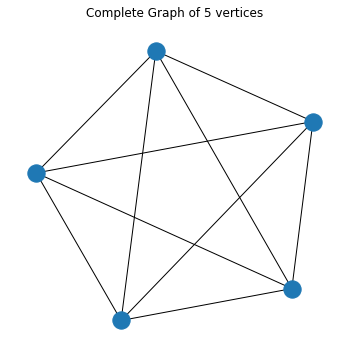

In [3]:
model = Model(
    [nx.Graph.number_of_edges],
    [None]
)

plt.figure(figsize=(6, 6))
plt.title('Complete Graph of 5 vertices')
pos = nx.spring_layout(complete_graph)
nx.draw(complete_graph, pos)
plt.show()

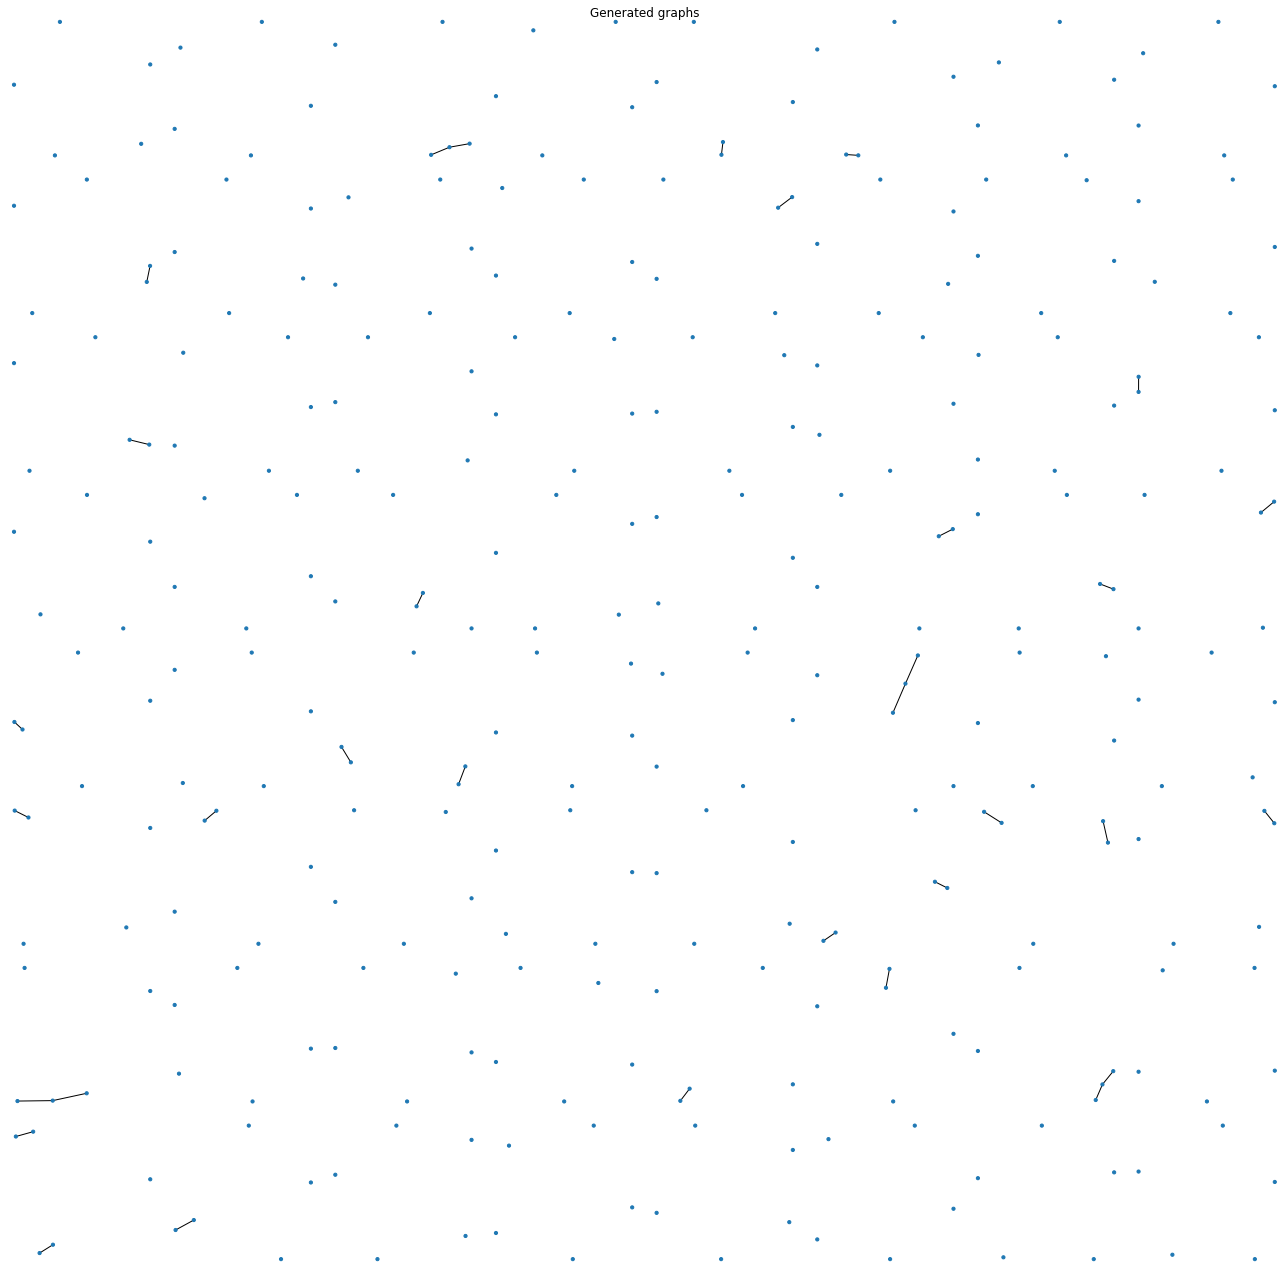

In [4]:
sample = sampling.metropolis_hastings(64, complete_graph, np.array([-3]), model, 1000, 1000)
# Parameter of -3

fig, axs = plt.subplots(8, 8, figsize=(18, 18))
fig.suptitle('Generated graphs')
for i in range(8):
    for j in range(8):
        G = sample[8 * i + j]
        pos = nx.spring_layout(G, scale=0.005)
        nx.draw(G, pos, axs[i, j], node_size=[10 for _ in G.nodes()])

plt.tight_layout()
plt.show()

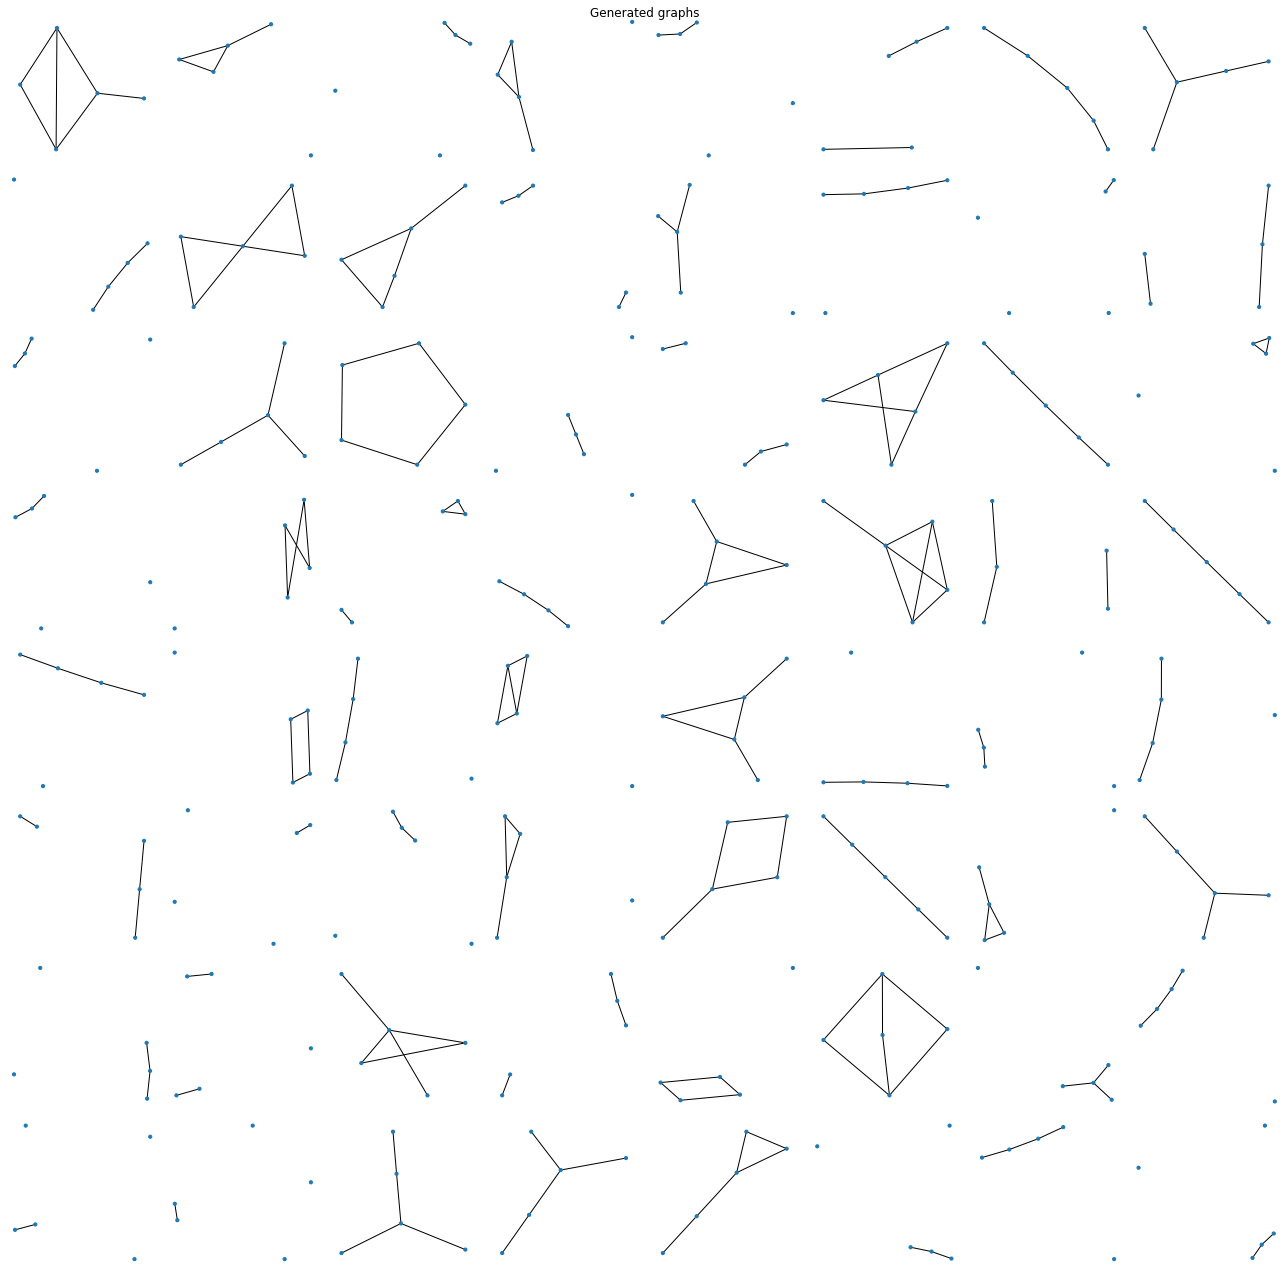

In [5]:
sample = sampling.metropolis_hastings(64, complete_graph, np.array([-0.5]), model, 1000, 1000)
# Parameter of -0.5

fig, axs = plt.subplots(8, 8, figsize=(18, 18))
fig.suptitle('Generated graphs')
for i in range(8):
    for j in range(8):
        G = sample[8 * i + j]
        pos = nx.spring_layout(G, scale=0.005)
        nx.draw(G, pos, axs[i, j], node_size=[10 for _ in G.nodes()])

plt.tight_layout()
plt.show()

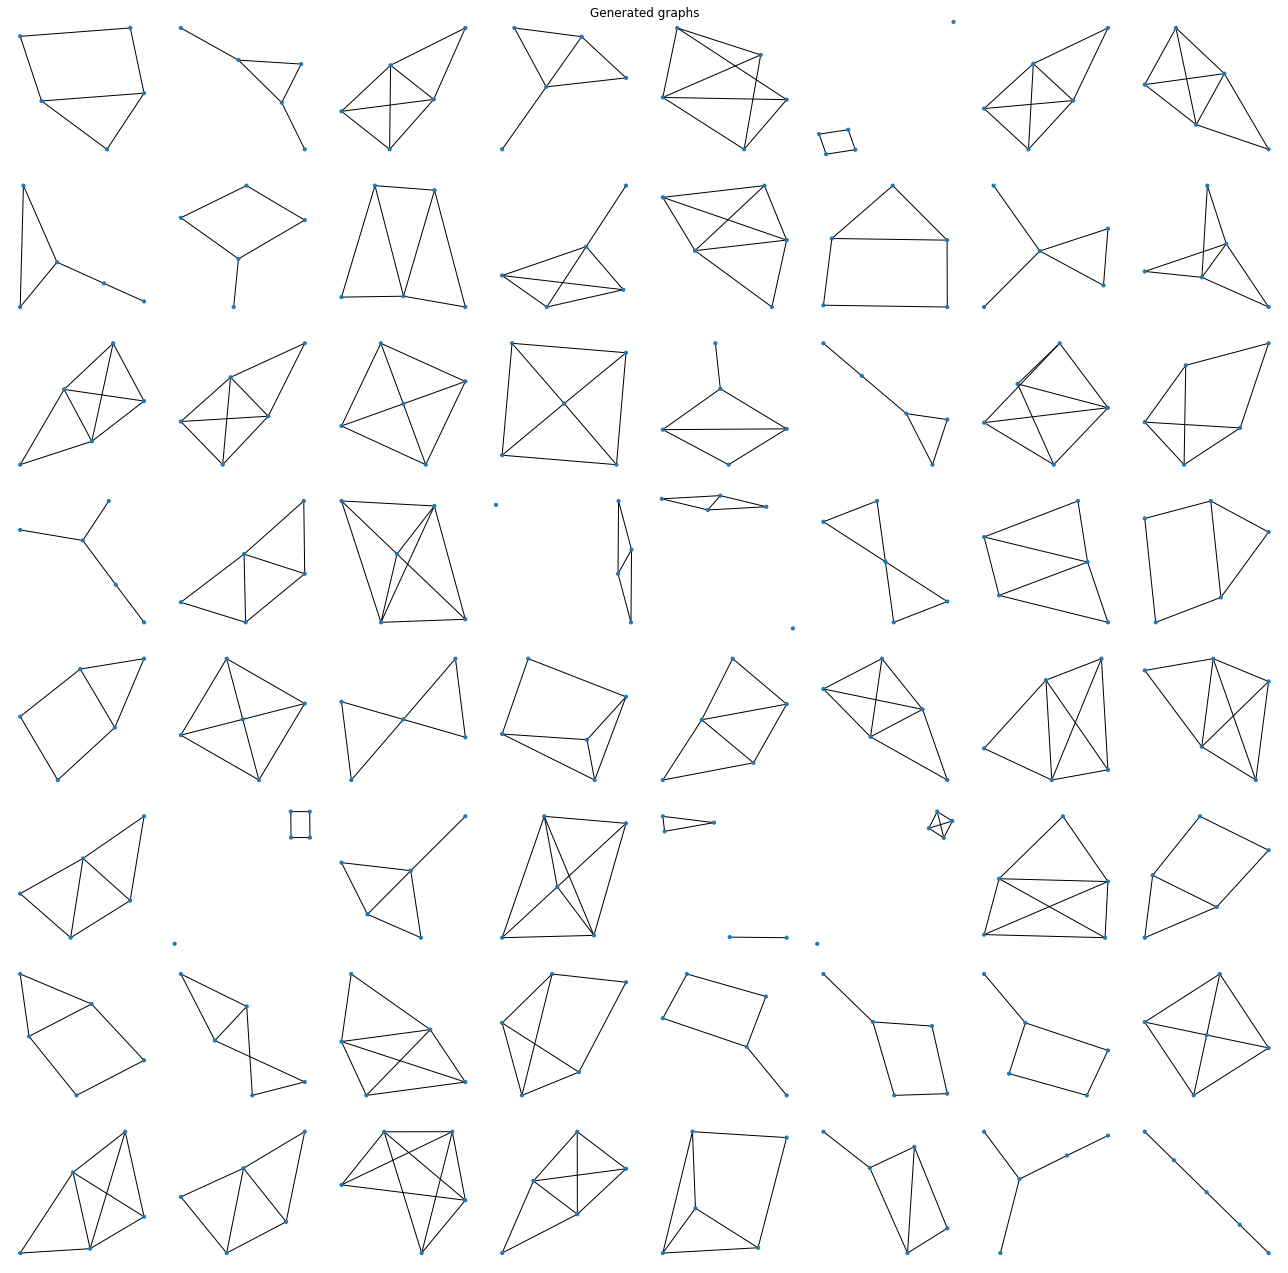

In [6]:
sample = sampling.metropolis_hastings(64, complete_graph, np.array([0.5]), model, 1000, 1000)
# Parameter of 0.5

fig, axs = plt.subplots(8, 8, figsize=(18, 18))
fig.suptitle('Generated graphs')
for i in range(8):
    for j in range(8):
        G = sample[8 * i + j]
        pos = nx.spring_layout(G, scale=0.005)
        nx.draw(G, pos, axs[i, j], node_size=[10 for _ in G.nodes()])

plt.tight_layout()
plt.show()

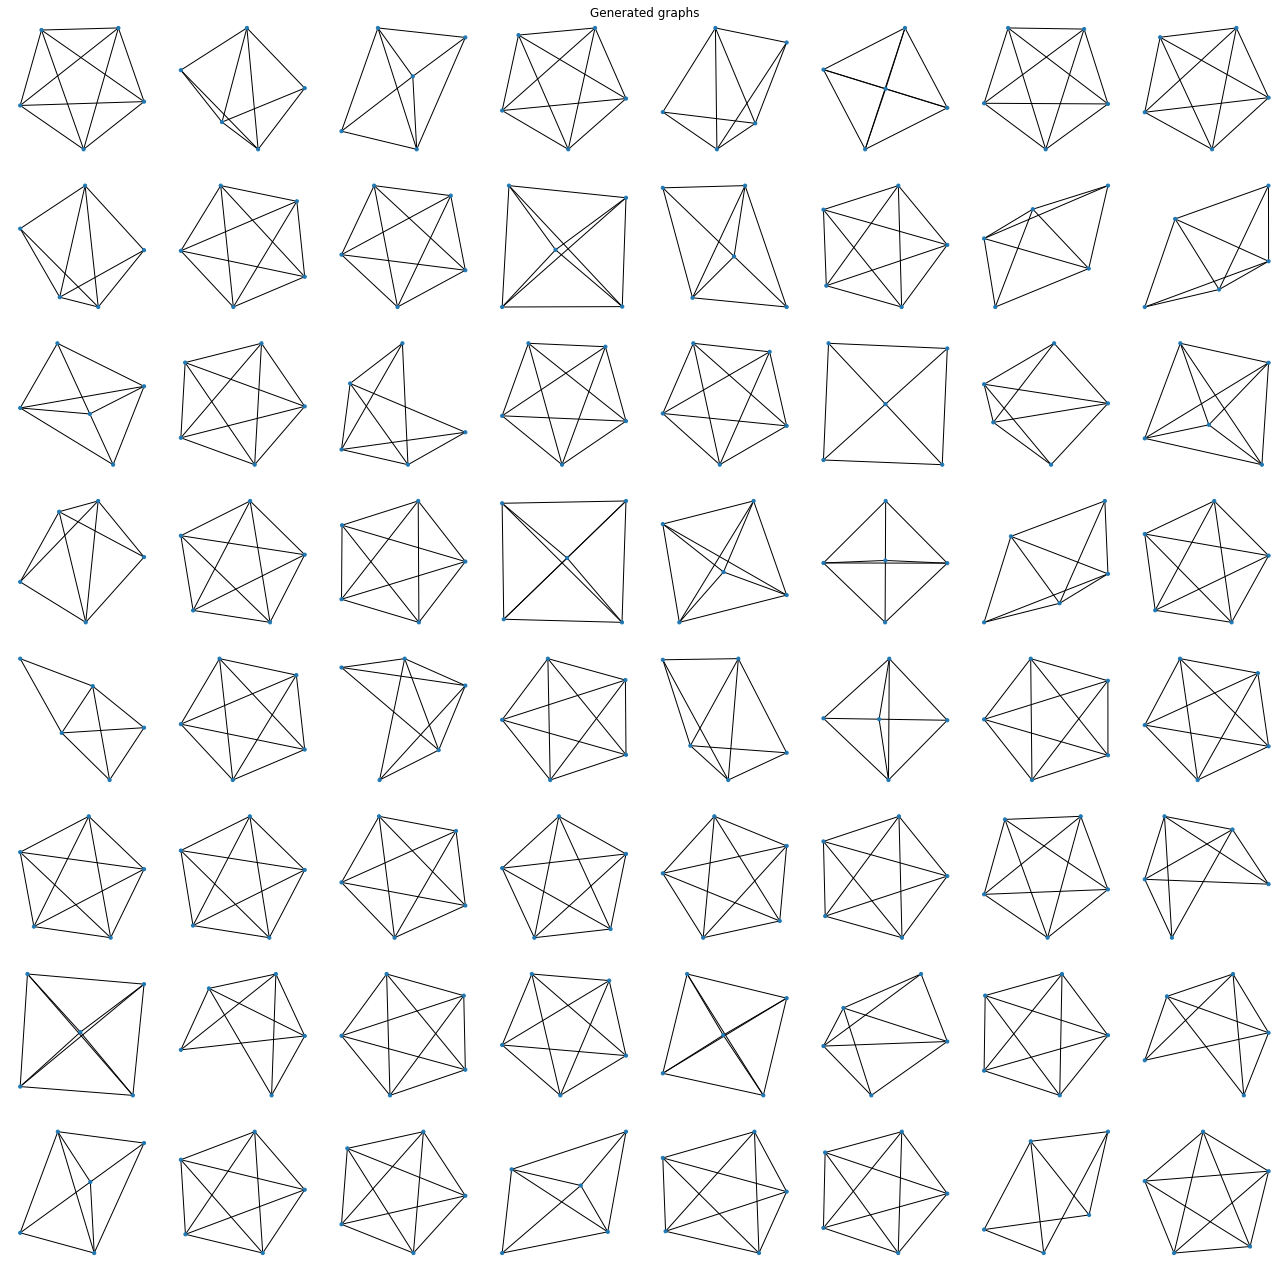

In [7]:
sample = sampling.metropolis_hastings(64, complete_graph, np.array([3]), model, 1000, 1000)
# Parameter of 3

fig, axs = plt.subplots(8, 8, figsize=(18, 18))
fig.suptitle('Generated graphs')
for i in range(8):
    for j in range(8):
        G = sample[8 * i + j]
        pos = nx.spring_layout(G, scale=0.005)
        nx.draw(G, pos, axs[i, j], node_size=[10 for _ in G.nodes()])

plt.tight_layout()
plt.show()

With the previous experiment, we are a little more confident on the function. Now, we'll use other sufficient statistics on other graphs.

Another statistic we can use is the *geometrically weighted degree*
$$
s_{gwd}(y, \phi) = e^\phi \sum_{l=1}^{n-1} (1 - (1 - e^{-\phi})^l)D_l(y),
$$
where $y$ is a graph of $n$ vertices, $\phi$ is a decay parameter that controls the weight of the degree and $D_l(y)$ is a function that computes the number of nodes that has a degree $l$. We see that if $\phi = 0$, then the degree has a *full* weight in the sum. Conversely, if $\phi \to \infty$, then the degree has no weight on the sum. Also, for a decay parameter $0 < \phi < \infty$, high degrees has less weight on the sum than low degrees because of the term $(1 - e^{-\phi})^l$.

The *geometrically weighted edgewise shared partners* is another interesting statistics that capture *triangles*. It is defined as
$$
s_{gwesp}(y, \phi) = e^\phi \sum_{l=1}^{n-2} (1 - (1 - e^{-\phi})^l)EP_l(y),
$$
where $y$ is a graph of $n$ vertices, $\phi$ is a decay parameter that controls the weight of the number of shared partners and $EP_l(y)$ is a function that computes the number of nodes that has $l$ neighbours in common.

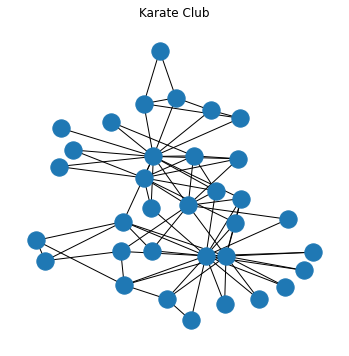

In [8]:
model = Model(
    [sufficient.geo_weighted_degree, sufficient.geo_weighted_ew_shared_partners],
    [[0.9], [0.8]]
)

plt.figure(figsize=(6, 6))
plt.title('Karate Club')
pos = nx.kamada_kawai_layout(karate_graph)
nx.draw(karate_graph, pos)
plt.show()

We can take a look to each statistics seperately and see if the algorithm had reached the equilibrium distribution.

Sufficient statistics of the Karate Club graph [66.92546457 91.801982  ]


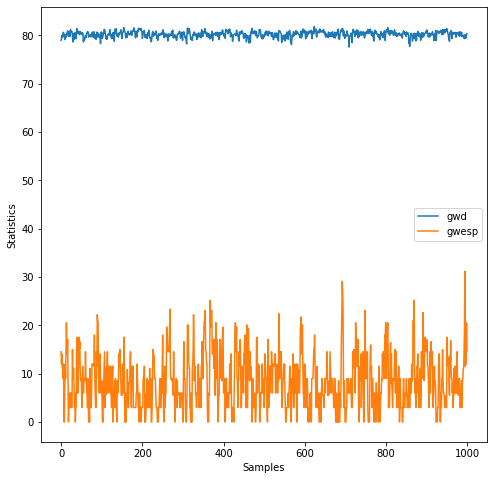

In [9]:
nsample = 1000
burnin = 1000
thinning = 100
sample = sampling.metropolis_hastings(nsample, karate_graph, np.array([0.25, -1]), model, burnin, thinning)
sufficient_vector = np.empty((nsample, 2))
for i, G in enumerate(sample):
    sufficient_vector[i, :] = model.sufficient(G)

print('Sufficient statistics of the Karate Club graph', model.sufficient(karate_graph))
plt.figure(figsize=(8, 8))
x = np.arange(sufficient_vector.shape[0])
plt.plot(x, sufficient_vector[:, 0])
plt.plot(x, sufficient_vector[:, 1])
plt.xlabel('Samples')
plt.ylabel('Statistics')
plt.legend(['gwd', 'gwesp'])
plt.show()

Sufficient statistics of the Karate Club graph [66.92546457 91.801982  ]


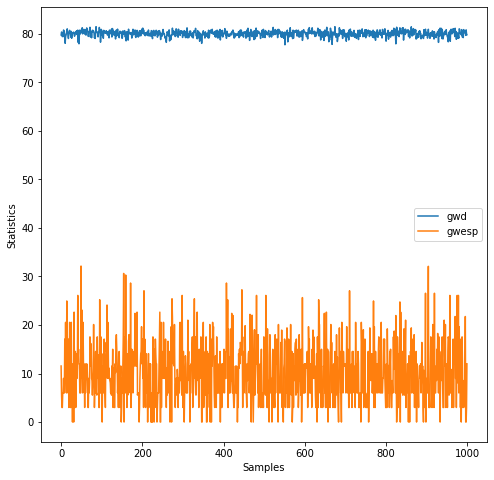

In [10]:
nsample = 1000
burnin = 1000
sample = sampling.parallel_metropolis_hastings(nsample, karate_graph, np.array([0.25, -1]), model, burnin)
sufficient_vector = np.empty((nsample, 2))
for i, G in enumerate(sample):
    sufficient_vector[i, :] = model.sufficient(G)

print('Sufficient statistics of the Karate Club graph', model.sufficient(karate_graph))
plt.figure(figsize=(8, 8))
x = np.arange(sufficient_vector.shape[0])
plt.plot(x, sufficient_vector[:, 0])
plt.plot(x, sufficient_vector[:, 1])
plt.xlabel('Samples')
plt.ylabel('Statistics')
plt.legend(['gwd', 'gwesp'])
plt.show()